## TensorFlow 实现进阶的卷积网络

### Cifar-10 数据集
    是一个经典的数据集,包含约60000张32x32的彩色图片.训练集50000张,测试集10000张.标注10个类.还有一个版本Cifar-100,标注了100个类.

In [12]:
import random
import numpy as np
import matplotlib.pyplot as plt
from utils.cifar10_utils import *

In [13]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'utils/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)

Training data shape:  (10000, 32, 32, 3)
Training labels shape:  (10000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [14]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


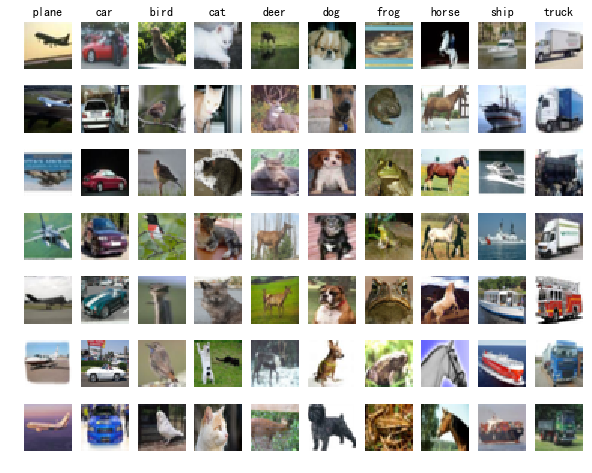

In [15]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
sample_num_cls = 7
# a Set means label and val
for cur_item_label_InVal, cur_item_label_InName in enumerate(classes):
    cur_item_set_Inytrain = np.flatnonzero(cur_item_label_InVal==y_train)
    cur_item_set_Rd7Ofytrain = np.random.choice(cur_item_set_Inytrain, sample_num_cls, replace=False)

    for set_pos, item_set_Val in enumerate(cur_item_set_Rd7Ofytrain):
        plt_idx = set_pos*num_classes+cur_item_label_InVal+1
        plt.subplot(sample_num_cls, num_classes, plt_idx)
        plt.imshow(X_train[item_set_Val].astype('uint8'))
        plt.axis('off')
        if set_pos == 0:
            plt.title(cur_item_label_InName)# 这个地方容易理解错
    
plt.show()

### 用tf来加载cifar10

这个tf的工具实现了对图片的翻转, 随机剪切等数据增强方法.

In [16]:
#!cd models/tutorials/image/cifar10/
import sys
#sys.path.append('models/tutorials/image/cifar10/') 

In [17]:
#from models.tutorials.image.cifar10.cifar10 import *
import cifar10,cifar10_input
import tensorflow as tf
import time

In [32]:
batch_size  = 3000
max_rounds = 128
data_dir = 'tmp/cifar10_data/cifar-10-batches-bin/cifar-10-batches-bin'
tf.app.flags.FLAGS.data_dir = data_dir

In [25]:
#!mkdir -p tmp/cifar10_data/cifar-10-batches-bin/

#### 1. 定义一个带L2正则的权重变量

In [41]:
def variable_weights_withL2loss(shape, stddev, wl):
    var = tf.Variable(tf.truncated_normal(shape, stddev=stddev))
    if wl is not None:
        weight_loss = tf.multiply(tf.nn.l2_loss(var),wl,name='weight_loss')
        tf.add_to_collection('losses',weight_loss)
    
    return var

#### 2. 加载cifar数据并翻转剪切

In [29]:
cifar10.maybe_download_and_extract()

In [33]:
images_train, labels_train = cifar10_input.distorted_inputs(data_dir,batch_size)

Filling queue with 20000 CIFAR images before starting to train. This will take a few minutes.


#### 3.生成测试数据

In [36]:
image_test, label_test =cifar10_input.inputs(eval_data=True,data_dir=data_dir,batch_size=batch_size)


#### 4. 输入数据创建

In [37]:
image_holder = tf.placeholder(tf.float32, [batch_size, 24,24,3])#输入源: 24x24尺寸,rgb3色
label_holder = tf.placeholder(tf.float32, [batch_size])

#### 5.第一个网络

输入: batch_size x 24x24 x3

权重: 5x5x64

输出: batch_size x 64

In [42]:
w1 = variable_weights_withL2loss(shape=[5,5,3,64],stddev=5e-2,wl=0.0)
k1 = tf.nn.conv2d(image_holder, w1, [1,1,1,1],padding='SAME')
b1 = tf.Variable(tf.constant(0.0,shape=[64]))
conv1 = tf.nn.bias_add(k1,b1)
conv1 = tf.nn.relu(conv1)
pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME')
norm1 = tf.nn.lrn(pool1,depth_radius=4,bias=1.0,alpha=0.001/9.0,beta=0.75)

#### 6.第二个网络

输入: w/2 x h/2 x 64

权重: 64x5x5x64

输出: w/4 x h/4 x 64


In [44]:
w2 = variable_weights_withL2loss([5,5,64,64],stddev=0.1,wl=0.2)
k2 = tf.nn.conv2d(norm1,w2,strides=[1,1,1,1],padding='SAME')
b2 = tf.Variable(tf.constant(0.0, shape=[64]))
conv2 = tf.nn.bias_add(k2, b2)
conv2 = tf.nn.relu(conv2)
norm2 = tf.nn.lrn(conv2,depth_radius=4,bias=1,alpha=0.001/0.9,beta=0.75)
pool2 = tf.nn.max_pool(norm2,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME')

#### 7.全连接层A
把二维的拉成一维的,用之前的经典神经网络来做,就叫做全连接层.

输入: batch_size x dim 

$$ c = \frac{S}{r}$$
其中,c为dim, r为batch_size, S为pool2的总数量

权重: dim x 384 (隐含层节点个数)

输出: batch_size x 384

In [54]:
image_reshape = tf.reshape(pool2,shape=[batch_size,-1]) #列不管,把行拉成batch_size个。这个也是说有batch_size个图像，每一行是一个图像。
dim = image_reshape.get_shape()[1].value
w3 = variable_weights_withL2loss(shape=[dim,384],stddev=0.1,wl=0.1)
b3 = tf.Variable(tf.constant(0.1, shape=[384]))
hidden3 = tf.matmul(image_reshape,w3) + b3
hidden3 = tf.nn.relu(hidden3)

#### 8.全连接层B

输入: batch_size x 384

权重: 384x192

输出: batch_size x 192


In [55]:
w4 = variable_weights_withL2loss(shape=[384,192],stddev=0.1,wl=0.1)
b4 = tf.Variable(tf.constant(0.1,shape=[192]))
hidden4 = tf.matmul(hidden3,w4) + b4
hidden4 = tf.nn.relu(hidden4)

#### 9.最后一层

输入: batch_size x 192

权重: 192x10

输出: batch_size x 10

In [ ]:
w5 = variable_weights_withL2loss(shape=[192,10],stddev=0.1, wl=0.1)
b5 = tf.Variable(tf.constant(0.0,shape=[10]))
out = tf.matmul(hidden4,w5) + b5
